In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.stats as sstats 

# A Typical Linear Problem

Consider the linear problem

$$
    q = Ax, \ x\in\mathbb{R}^n, \ q\in \mathbb{R}^p, \ A\in\mathbb{R}^{p\times n}
$$

where we assume that $p\leq n$ and $A$ is rank $p$. 

# Statistical Bayesian connection to Tikhonov regularization

Assuming we observe datum $\tilde{q}$ and that we are using a Gaussian prior ($N(\bar{x},C_x)$) and Gaussian noise model ($N(0,C_q)$), the statistical Bayesian posterior is given by

$$
    \pi^{\text{post}} \propto \exp\left(-\frac{1}{2}\left( 
    \underbrace{\left|\left|C_q^{-1/2}(q-\tilde{q})\right|\right|_2^2}_{\text{Data mismatch}} + 
    \underbrace{\left|\left|C_x^{-1/2}(x-\bar{x})\right|\right|_2^2}_{\text{Tikhonov regularization}}
    \right)\right)
$$

where we have made explicit the connection of the MAP (maximum a posteriori) point of the posterior density with the Tikhnoov regularized solution to a deterministic optimization problem.

See https://en.wikipedia.org/wiki/Tikhonov_regularization for more information.

## Take-aways


* The model defines the data mismatch and the prior defines the regularization. 


* The regularization impacts ***all directions*** of the posterior since we effectively balance the data mismatch with our prior beliefs. This implies that the "solution" defined by a MAP point is not necessarily a point that produces the observed datum.

# Consistent Bayesian and *unregularization*

The statistical Bayesian posterior is given by the prior times the likelihood function divided by a normalizing constant.
However, the consistent Bayesian posterior is given by the observed density times the prior density divided by the push-forward of the prior density.
In this problem, with the same assumptions as above, the push-forward is Gaussian with covariance given by $C_A=AC_xA^\top$ and mean given by $\bar{q}=A\bar{x}$. 
Thus, the consistent Bayesian posterior is given by

$$
    \pi^{\text{post}} \sim \exp\left(-\frac{1}{2}\left( 
    \underbrace{\left|\left|C_q^{-1/2}(q-\tilde{q})\right|\right|_2^2}_{\text{Data mismatch}} 
    + 
    \underbrace{\left|\left|C_x^{-1/2}(x-\bar{x})\right|\right|_2^2}_{\text{Tikhonov regularization}}
    - 
    \underbrace{\left|\left|C_A^{-1/2}(q-\bar{q})\right|\right|_2^2}_{\text{unregularization}}
    \right)\right)
$$

where we have categorized the effect of dividing by the push-forward as a source of ***unregularization*** in the MAP point.
To see this even more clearly, observe that we can collect and rewrite the regularization terms as

$$
    \left|\left|C_x^{-1/2}(x-\bar{x})\right|\right|_2^2 - \left|\left|C_A^{-1/2}(q-\bar{q})\right|\right|_2^2 = (x-\bar{x})^\top\underbrace{\left(C_x^{-1}-A^\top(AC_xA^\top)^{-1}\right)}_{R}(x-\bar{x})
$$

where $R$ is the ***regularization matrix***.

## Take-aways


* If $A$ is rank $n$ and invertible, then $R=0$. In other words, regularization is ***turned off*** if there is a unique solution.

# Example

Consider the linear problem where
$$
    A = [2 \ -1],\ \bar{x}=\left[\begin{array}[c]  00.2 \\ 0.2 \end{array}\right], \ C_x = \text{diag}(0.5, 0.25), \ \tilde{q} = [0.1], \ C_q = [0.25].
$$

## Things to play with

* Try changing the `x_prior` in the code to something other than $[0.2 \ 0.2]^\top$ to make the prior guess either better or worse. What happens?

* Try playing with the `C_x` covariance to give the prior guess either more confidence (reduce the components) or less confidence (increase the components). What happens?

In [16]:
# Setup example and prior guess, prior prediction, and actual datum

A = np.array([[2, -1]]) #map
x_prior = np.array([[0.2, 0.2]]).transpose() #prior guess of mean
q_obs = np.array([0.1]) #actual datum
q_prior = np.dot(A,x_prior) #predicted datum using prior

In [3]:
# Setup all the covariances

C_x = np.diag([0.5,0.25]) #prior covariance
C_q = np.diag([0.25]) #data covariance
C_A = np.dot(np.dot(A,C_x),A.transpose()) #the "covariance of the map"

In [4]:
# define the various weighted sum squares of errors (WSSE) given by 
# the data misfit, Tikhonov regularization, and unregularization terms. 

def data_misfit(x):
    C_q_inv = np.linalg.inv(C_q)
    q = np.dot(A,x)
    WSSE = np.vdot(np.dot(C_q_inv,q-q_obs),q-q_obs) #weighted sum-squared error
    return WSSE
    
def Tikhonov_reg(x):
    C_x_inv = np.linalg.inv(C_x)
    WSSE = np.vdot(np.dot(C_x_inv,x-x_prior),x-x_prior) #weighted sum-squared error
    return WSSE

def unregularize(x):
    C_A_inv = np.linalg.inv(C_A)
    q = np.dot(A,x)
    WSSE = np.vdot(np.dot(C_A_inv,q-q_prior),q-q_prior) #weighted sum-squared error
    return WSSE

In [5]:
# Discretize a portion of the input space R^2

n = 101
x1 = np.linspace(-0.5,0.5,n)
x2 = x1
x1,x2 = np.meshgrid(x1,x2)

In [6]:
# Compute all the WSSE terms

WSSE = np.zeros((n,n))
TSSE = np.zeros((n,n))
USSE = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        WSSE[j,i] = data_misfit(np.array([[x1[j,i],x2[j,i]]]).transpose())
        TSSE[j,i] = Tikhonov_reg(np.array([[x1[j,i],x2[j,i]]]).transpose())
        USSE[j,i] = unregularize(np.array([[x1[j,i],x2[j,i]]]).transpose())

<IPython.core.display.Javascript object>


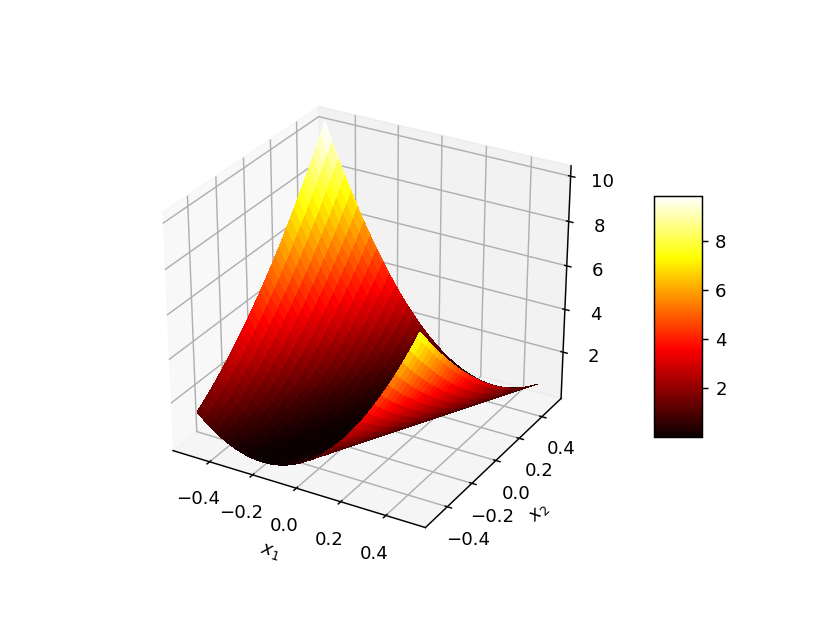

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, WSSE, cmap=cm.hot,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

<IPython.core.display.Javascript object>


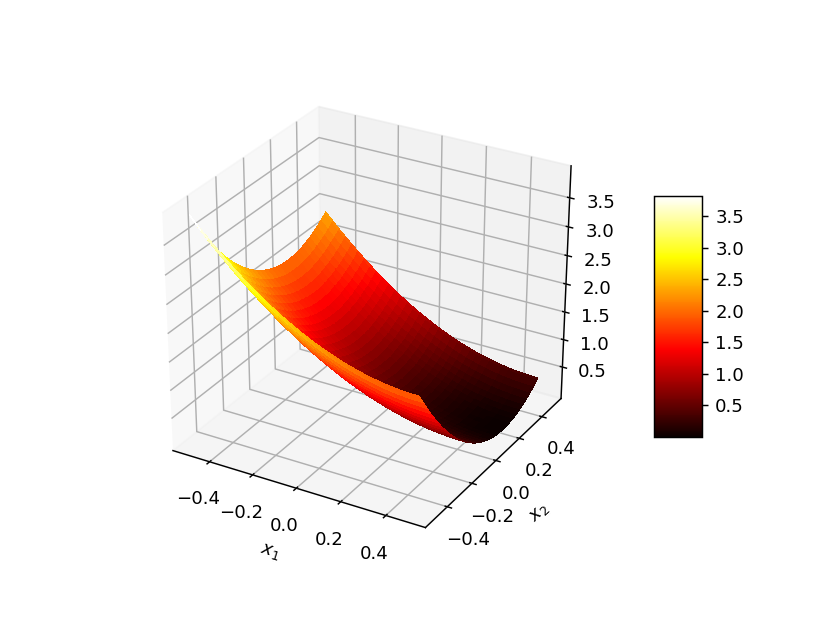

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, TSSE, cmap=cm.hot,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

<IPython.core.display.Javascript object>


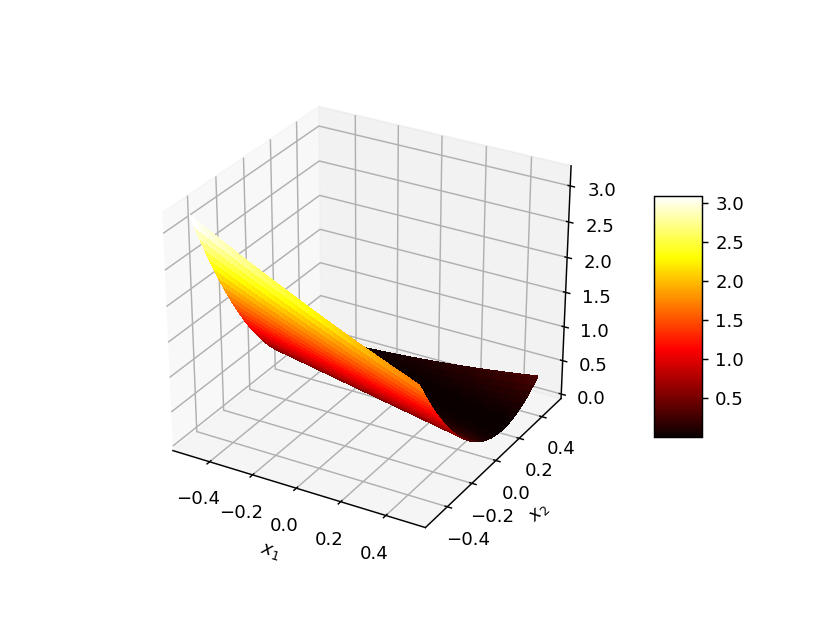

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, TSSE-USSE, cmap=cm.hot,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

<IPython.core.display.Javascript object>


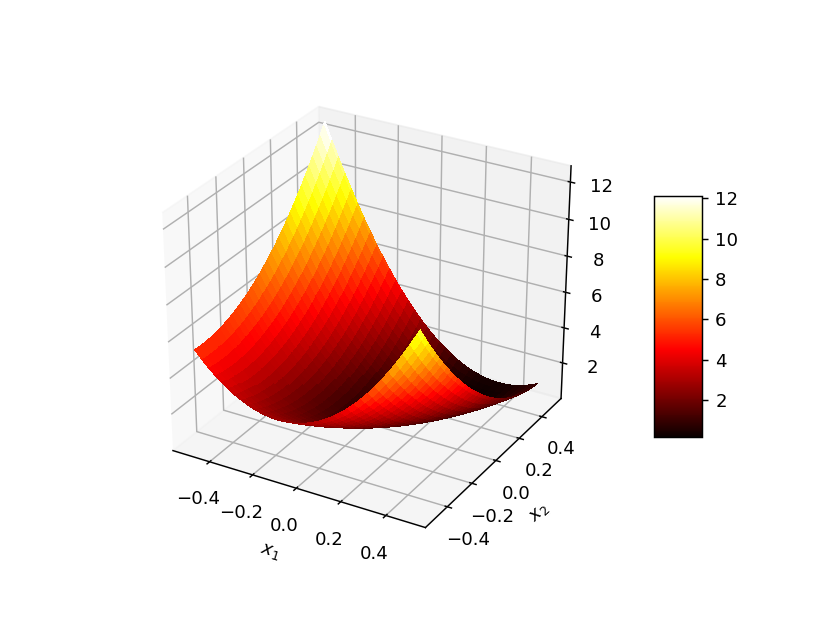

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, WSSE + TSSE, cmap=cm.hot,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

<IPython.core.display.Javascript object>


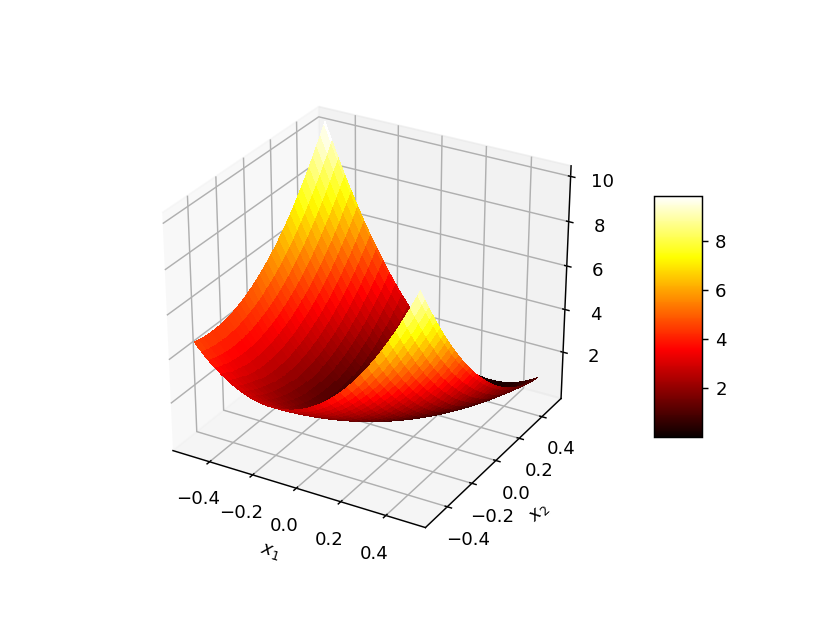

In [11]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, WSSE + TSSE - USSE, cmap=cm.hot,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [12]:
x_reg_ind = np.argmin(WSSE+TSSE)
print([x1.flatten()[x_reg_ind],x2.flatten()[x_reg_ind]])

[0.21999999999999997, 0.27]


In [13]:
x_unreg_ind = np.argmin(WSSE+TSSE-USSE)
print([x1.flatten()[x_unreg_ind],x2.flatten()[x_unreg_ind]])

[0.19000000000000006, 0.28]


In [14]:
print(np.dot(A,[x1.flatten()[x_reg_ind],x2.flatten()[x_reg_ind]]))

[0.17]


In [15]:
print(np.dot(A,[x1.flatten()[x_unreg_ind],x2.flatten()[x_unreg_ind]]))

[0.1]
